In [1]:
from pylab import *

import sys
sys.path.insert(0, 'velocitySlamSeq//slam_seq')

from dynamo_fitting import *
%matplotlib inline 

In [2]:
def sol_s_bg(t, s0, u0, alpha, beta):
    exp_bt = exp(-beta*t)
    return s0*exp_bt + (beta*u0-alpha)*t*exp_bt + alpha/gamma * (1-exp_bt)

In [3]:
def sol_s_bg2(t, s0, u0, alpha, beta):
    exp_bt = np.exp(-beta*t)
    return s0*exp_bt + alpha/beta * (1-exp_bt)

# Degradation Experiment:
The labeling is stopped at $t=0$, and therefore the degradation of the labeled species (unspliced & spliced) can be used to estimate $\beta$ and $\gamma$.<br>
The synthesis of unlabeled species can be used to estimate $\alpha$.


$u$ - unlabeled, unspliced<br>
$s$ - unlabeled, spliced<br>
$w$ - labeled, unspliced<br>
$l$ - labeled, spliced<br>

## Data Synthesis:

In [4]:
# true parameters
beta_true = 0.5; gamma_true = 0.25; alpha_true = 100;
# true initial conditions
u0_true = 20; s0_true = 30;
w0_true = 50; l0_true = 80;
# generate data
T = array([0, 2, 4, 8])
w = sol_u(T, w0_true, 0, beta_true) + (rand(3, len(T)) - 0.5) * 10
l = sol_s(T, l0_true, w0_true, 0, beta_true, gamma_true) + (rand(3, len(T)) - 0.5) * 10
u = sol_u(T, u0_true, alpha_true, beta_true) + (rand(3, len(T)) - 0.5) * 10
s = sol_s(T, s0_true, u0_true, alpha_true, beta_true, gamma_true) + (rand(3, len(T)) - 0.5) * 10
w[w<=0] = 1
l[l<=0] = 1

Text(0,0.5,'s')

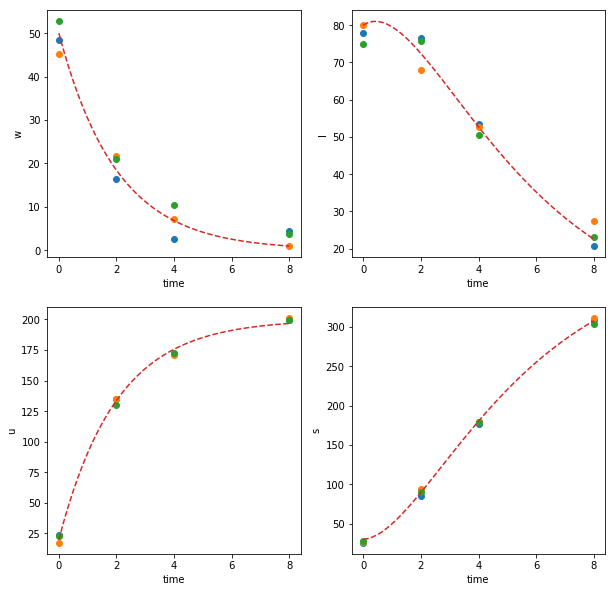

In [5]:
t = linspace(T[0], T[-1], 50)
figure(figsize=(10, 10))
subplot(221)
plot(T, w.T, 'o')
plot(t, sol_u(t, w0_true, 0, beta_true), '--')
xlabel('time')
ylabel('w')

subplot(222)
plot(T, l.T, 'o')
plot(t, sol_s(t, l0_true, w0_true, 0, beta_true, gamma_true), '--')
xlabel('time')
ylabel('l')

subplot(223)
plot(T, u.T, 'o')
plot(t, sol_u(t, u0_true, alpha_true, beta_true), '--')
xlabel('time')
ylabel('u')

subplot(224)
plot(T, s.T, 'o')
plot(t, sol_s(t, s0_true, u0_true, alpha_true, beta_true, gamma_true), '--')
xlabel('time')
ylabel('s')

## Beta Estimation:
The labeled, unspliced mRNA ($w$) follows a first-order degradation, of which solution is:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w(t) = w_0e^{-\beta t}$
    
To estimate the two parameters $w_0$ and $\beta$, we perform the following transform:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\ln w = \ln w_0 -\beta t$

Then using simple linear regression, with $y=\ln w$ and $x=t$, $\beta$ and $w_0$ can be computed as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\beta = -k$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_0 = e^b$ <br>

where $k$ and $b$ are the slope and the intercept, respectively, of the linear regression model.

In [6]:
beta, w0 = fit_gamma_labeling(T, w, lbound=1)
print ('beta = %.4f'%beta)
print ('w0 = %.4f'%w0)

beta = 0.3706
w0 = 39.6996


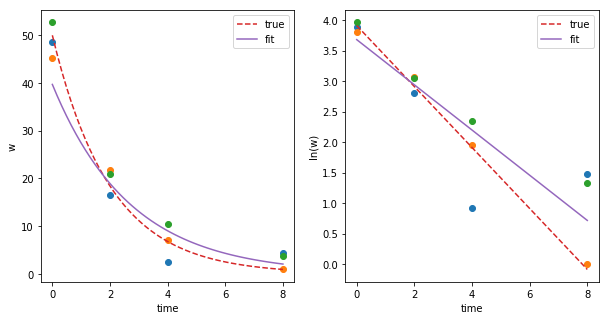

In [8]:
figure(figsize=(10, 5))
subplot(121)
plot(T, w.T, 'o')
plot(t, sol_u(t, w0_true, 0, beta_true), '--', label='true')
plot(t, sol_u(t, w0, 0, beta), label='fit')
xlabel('time')
ylabel('w')
legend()

subplot(122)
plot(T, log(w).T, 'o')
plot(t, log(sol_u(t, w0_true, 0, beta_true)), '--', label='true')
plot(t, log(sol_u(t, w0, 0, beta)), label='fit')
xlabel('time')
ylabel('ln(w)')
legend()

## Gamma Estimation
The labeled, spliced mRNA ($l$) has the following form:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $l(t) = l_0e^{-\gamma t} - \dfrac{\beta w_0}{\gamma-\beta}\Big(e^{-\gamma t} - e^{-\beta t}\Big)$, for $\beta \neq \gamma$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $l(t) = l_0e^{-\gamma t} - \beta w_0\ te^{-\gamma t}$, for $\beta = \gamma$

Which can be used to estimate $\gamma$ and $l_0$, if $\beta$ and $w_0$ have been estimated. However, this cannot be transformed into a linear regression model, so instead a least square fitting is used.

In [9]:
#gamma, l0 = fit_gamma_splicing(hstack((T, T, T)), l.flatten(), beta, w0)
gamma, l0 = fit_gamma_splicing(T, l, beta, w0)
print ('gamma = %.4f'%gamma)
print ('l0 = %.4f'%l0)

gamma = 0.2138
l0 = 79.9950


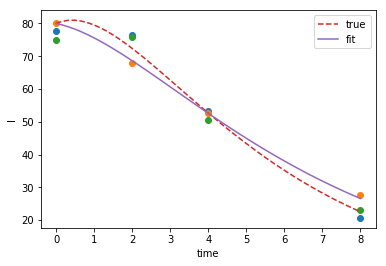

In [10]:
figure()
plot(T, l.T, 'o')
plot(t, sol_s(t, l0_true, w0_true, 0, beta_true, gamma_true), '--', label='true')
plot(t, sol_s(t, l0, w0, 0, beta, gamma), label='fit')
xlabel('time')
ylabel('l')
legend()

The initial guess for $l_0$ is computed by taking the average of $l$ at $t=0$. The initial guess for $\gamma$ is computed under the steady state assumption that: <br>
$0 = \beta w_0 - \gamma l_0\ \Rightarrow\ \gamma = \beta \dfrac{w_0}{l_0}$ <br>
As shown below, the loss, defined as the sum of squares of residual between the solution and data, has a unique minimum. Therefore, the global optima can be obtained even if the initial guess is bad.

Text(0,0.5,'loss')

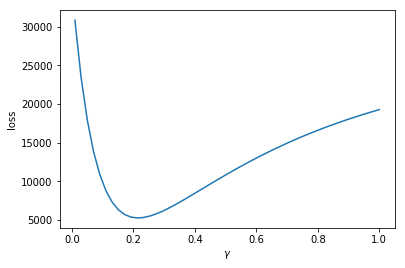

In [11]:
G = linspace(0.01, 1, 50)
loss = zeros(G.shape)
for i, g in enumerate(G):
    loss[i] = sum((sol_s(T, w0, mean(l[:, 0]), 0, beta, g) - l)**2)
plot(G, loss)
xlabel('$\gamma$')
ylabel('loss')

## Alpha Estimation:
The unlabeled, unspliced mRNA ($u$) increases with time due to a constant synthesis rate $\alpha$. The solution is:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $u(t) = u_0e^{-\beta t} + \dfrac{\alpha}{\beta}\Big(1-e^{-\beta t}\Big)$

This can be transformed into a linear regression model:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ue^{\beta t} = u_0 + \dfrac{\alpha}{\beta}\Big(e^{\beta t} - 1\Big)$

so that $y=ue^{\beta t}$ and $x=e^{\beta t} - 1$. $\alpha$ and $u_0$ can be computed as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\alpha = \beta k$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $u_0 = b$

where $k$ and $b$ are the slope and the intercept, respectively, of the linear regression model.

In [12]:
alpha, u0 = fit_alpha_labeling(T, u, beta)
print ('alpha = %.4f'%alpha)
print ('u0 = %.4f'%u0)

alpha = 77.4583
u0 = 38.3898


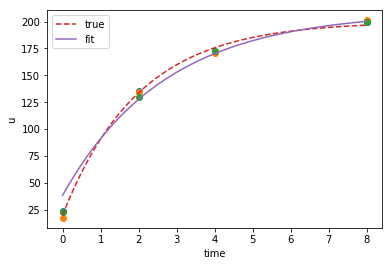

In [13]:
plot(T, u.T, 'o')
plot(t, sol_u(t, u0_true, alpha_true, beta_true), '--', label='true')
plot(t, sol_u(t, u0, alpha, beta), label='fit')
xlabel('time')
ylabel('u')
legend()

# Kinetics Experiment:
The labeling begins at $t=0$, and therefore the degradation of the unlabeled species (unspliced & spliced) can be used to estimate $\beta$ and $\gamma$.<br>
The synthesis of labeled species can be used to estimate $\alpha$.

$u$ - unlabeled, unspliced<br>
$s$ - unlabeled, spliced<br>
$w$ - labeled, unspliced<br>
$l$ - labeled, spliced<br>

In [14]:
# true parameters
beta_true = 0.5; gamma_true = 0.25; alpha_true = 100;
# true initial conditions
u0_true = 20; s0_true = 30;
# generate data
T = array([0, 2, 4, 8])
Tl = array([0, 2])
w = sol_u(Tl, 0, alpha_true, beta_true) + (rand(3, len(Tl)) - 0.5) * 10
l = sol_s(Tl, 0, 0, alpha_true, beta_true, gamma_true) + (rand(3, len(Tl)) - 0.5) * 10
u = sol_u(T, u0_true, 0, beta_true) + (rand(3, len(T)) - 0.5) * 10
s = sol_s(T, s0_true, u0_true, 0, beta_true, gamma_true) + (rand(3, len(T)) - 0.5) * 10
w[w<=0] = 1
l[l<=0] = 1
u[u<=0] = 1
s[s<=0] = 1

Text(0,0.5,'s')

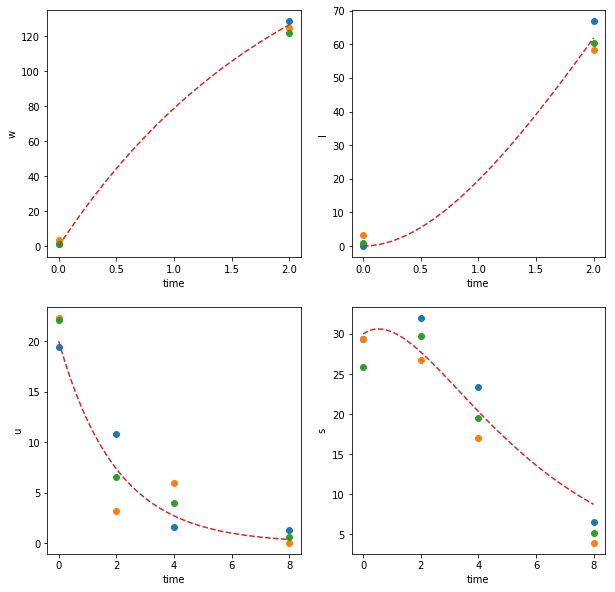

In [15]:
tl = linspace(Tl[0], Tl[-1], 50)
t = linspace(T[0], T[-1], 50)

figure(figsize=(10, 10))
subplot(221)
plot(Tl, w.T, 'o')
plot(tl, sol_u(tl, 0, alpha_true, beta_true), '--')
xlabel('time')
ylabel('w')

subplot(222)
plot(Tl, l.T, 'o')
plot(tl, sol_s(tl, 0, 0, alpha_true, beta_true, gamma_true), '--')
xlabel('time')
ylabel('l')

subplot(223)
plot(T, u.T, 'o')
plot(t, sol_u(t, u0_true, 0, beta_true), '--')
xlabel('time')
ylabel('u')

subplot(224)
plot(T, s.T, 'o')
plot(t, sol_s(t, s0_true, u0_true, 0, beta_true, gamma_true), '--')
xlabel('time')
ylabel('s')

## Beta Estimation:
The unlabeled, unspliced mRNA ($u$) follows a first-order degradation, of which solution is:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $u(t) = u_0e^{-\beta t}$
    
To estimate the two parameters $u_0$ and $\beta$, we perform the following transform:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\ln u = \ln u_0 -\beta t$

Then using simple linear regression, with $y=\ln u$ and $x=t$, $\beta$ and $u_0$ can be computed as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\beta = -k$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $u_0 = e^b$ <br>

where $k$ and $b$ are the slope and the intercept, respectively, of the linear regression model.

In [16]:
beta, u0 = fit_gamma_labeling(T, u, lbound=1)
print ('beta = %.4f'%beta)
print ('u0 = %.4f'%u0)

beta = 0.3652
u0 = 16.4284


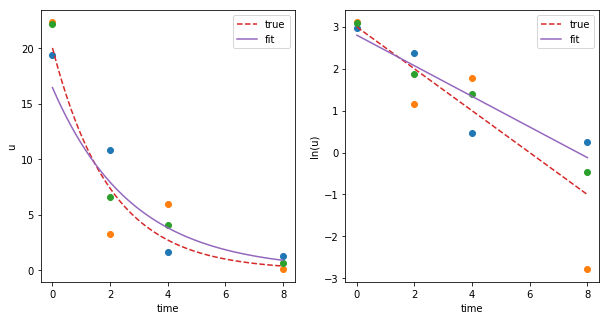

In [17]:
figure(figsize=(10, 5))
subplot(121)
plot(T, u.T, 'o')
plot(t, sol_u(t, u0_true, 0, beta_true), '--', label='true')
plot(t, sol_u(t, u0, 0, beta), label='fit')
xlabel('time')
ylabel('u')
legend()

subplot(122)
plot(T, log(u).T, 'o')
plot(t, log(sol_u(t, u0_true, 0, beta_true)), '--', label='true')
plot(t, log(sol_u(t, u0, 0, beta)), label='fit')
xlabel('time')
ylabel('ln(u)')
legend()

## Gamma Estimation
The unlabeled, spliced mRNA ($s$) has the following form:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s(t) = s_0e^{-\gamma t} - \dfrac{\beta u_0}{\gamma-\beta}\Big(e^{-\gamma t} - e^{-\beta t}\Big)$, for $\beta \neq \gamma$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s(t) = s_0e^{-\gamma t} - \beta u_0\ te^{-\gamma t}$, for $\beta = \gamma$

Which can be used to estimate $\gamma$ and $s_0$, if $\beta$ and $u_0$ have been estimated. However, this cannot be transformed into a linear regression model, so instead a least square fitting is used.

In [18]:
gamma, s0 = fit_gamma_splicing(T, s, beta, u0)
print ('gamma = %.4f'%gamma)
print ('s0 = %.4f'%s0)

gamma = 0.2355
s0 = 30.3984


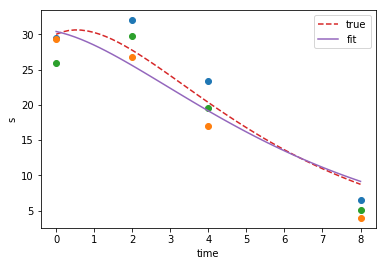

In [19]:
figure()
plot(T, s.T, 'o')
plot(t, sol_s(t, s0_true, u0_true, 0, beta_true, gamma_true), '--', label='true')
plot(t, sol_s(t, s0, u0, 0, beta, gamma), label='fit')
xlabel('time')
ylabel('s')
legend()

## Alpha Estimation:
The labeled, unspliced mRNA ($u$), starting from 0, increases with time due to a constant synthesis rate $\alpha$. The solution is:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $u(t) = \dfrac{\alpha}{\beta}\Big(1-e^{-\beta t}\Big)$

This can be transformed into a linear regression model with a fixed intercept of 0, where $y = u$ and $x = 1-e^{-\beta t}$. Then, $\alpha$ can be computed as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\alpha = \beta k = \dfrac{\langle u \rangle}{\langle 1-e^{-\beta t} \rangle}$ <br>

Where the angled bracket means average.

In [20]:
alpha = fit_alpha_synthesis(Tl, w, beta)
print ('alpha = %.4f'%alpha)

alpha = 89.3021


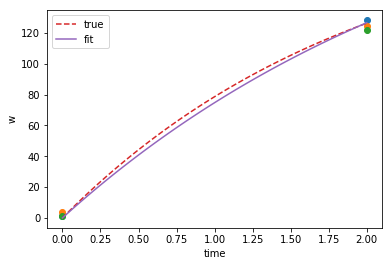

In [21]:
figure()
plot(Tl, w.T, 'o')
plot(tl, sol_u(tl, 0, alpha_true, beta_true), '--', label='true')
plot(tl, sol_u(tl, 0, alpha, beta), label='fit')
xlabel('time')
ylabel('w')
legend()